In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [3]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [4]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [5]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8773 - loss: 0.4332
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9664 - loss: 0.1148
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9792 - loss: 0.0718
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9847 - loss: 0.0507
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9889 - loss: 0.0369


In [6]:
test_digits = test_images[0:10]
predictions = model.predict(test_digits)
predictions[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([5.6806531e-08, 7.9358129e-09, 5.3228432e-06, 1.1385365e-04,
       4.3460496e-11, 7.9930871e-08, 2.4728388e-12, 9.9988008e-01,
       1.2606964e-07, 4.7360385e-07], dtype=float32)

In [7]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"테스트 정확도 : {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.9767 - loss: 0.0766
테스트 정확도 : 0.9801999926567078


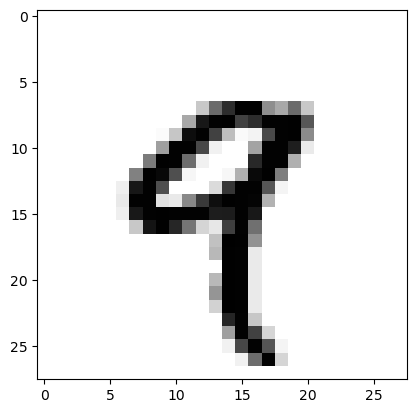

In [9]:
import matplotlib.pyplot as plt

digit = train_images[4].reshape(28, 28)
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [10]:
import tensorflow as tf


class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

In [11]:
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x

    @property
    def weights(self):
        weights = []
        for layer in self.layers:
            weights += layer.weights
        return weights

In [12]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

In [13]:
import math


class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        assert len(images) == len(labels)
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images) / batch_size)

    def next(self):
        images = self.images[self.index: self.index + self.batch_size]
        labels = self.labels[self.index: self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

In [14]:
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
    gradients = tape.gradient(average_loss, model.weights)
    update_weights(gradients, model.weights)
    return average_loss

In [15]:
learning_rate = 1e-3


def update_weights(gradients, weights):
    for g, w in zip(gradients, weights):
        w.assign_sub(learning_rate * g)

In [16]:
from tensorflow.keras import optimizers

optimizer = optimizers.SGD(learning_rate=1e-3)


def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

In [17]:
def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print(f"에포크 {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"{batch_counter}번째 배치 손실 : {loss:.2f}")

In [20]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)

에포크 0
0번째 배치 손실 : 5.14
100번째 배치 손실 : 2.23
200번째 배치 손실 : 2.21
300번째 배치 손실 : 2.07
400번째 배치 손실 : 2.23
에포크 1
0번째 배치 손실 : 1.89
100번째 배치 손실 : 1.86
200번째 배치 손실 : 1.83
300번째 배치 손실 : 1.68
400번째 배치 손실 : 1.82
에포크 2
0번째 배치 손실 : 1.56
100번째 배치 손실 : 1.56
200번째 배치 손실 : 1.50
300번째 배치 손실 : 1.39
400번째 배치 손실 : 1.49
에포크 3
0번째 배치 손실 : 1.29
100번째 배치 손실 : 1.32
200번째 배치 손실 : 1.23
300번째 배치 손실 : 1.17
400번째 배치 손실 : 1.25
에포크 4
0번째 배치 손실 : 1.10
100번째 배치 손실 : 1.15
200번째 배치 손실 : 1.04
300번째 배치 손실 : 1.02
400번째 배치 손실 : 1.08
에포크 5
0번째 배치 손실 : 0.95
100번째 배치 손실 : 1.01
200번째 배치 손실 : 0.90
300번째 배치 손실 : 0.90
400번째 배치 손실 : 0.96
에포크 6
0번째 배치 손실 : 0.84
100번째 배치 손실 : 0.91
200번째 배치 손실 : 0.80
300번째 배치 손실 : 0.81
400번째 배치 손실 : 0.87
에포크 7
0번째 배치 손실 : 0.76
100번째 배치 손실 : 0.82
200번째 배치 손실 : 0.72
300번째 배치 손실 : 0.75
400번째 배치 손실 : 0.81
에포크 8
0번째 배치 손실 : 0.70
100번째 배치 손실 : 0.76
200번째 배치 손실 : 0.66
300번째 배치 손실 : 0.69
400번째 배치 손실 : 0.76
에포크 9
0번째 배치 손실 : 0.65
100번째 배치 손실 : 0.70
200번째 배치 손실 : 0.61
300번째 배치 손실 : 0.65
400번째 배치 손실 : 0.72


In [22]:
import numpy as np

predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"정확도 : {matches.mean():.2f}")

정확도 : 0.81
